In [48]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
from nilearn import plotting
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.resnet50 import ResNet50

os.chdir('../Baseline')
os.getcwd()

'C:\\Users\\Ben\\Desktop\\Baseline'

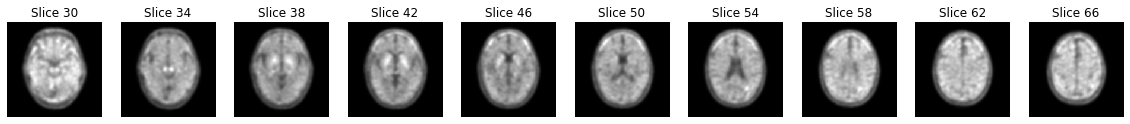

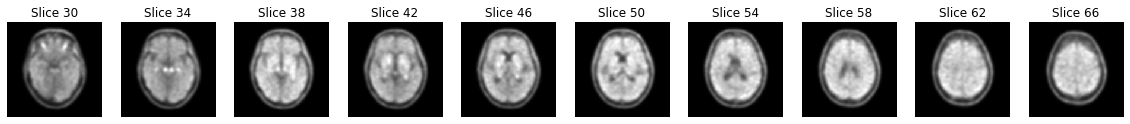

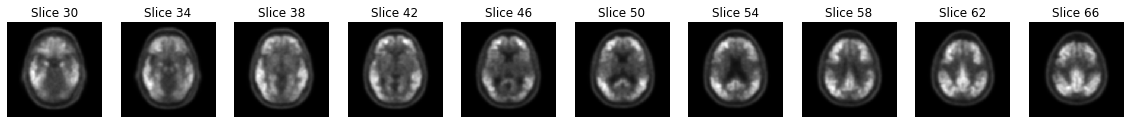

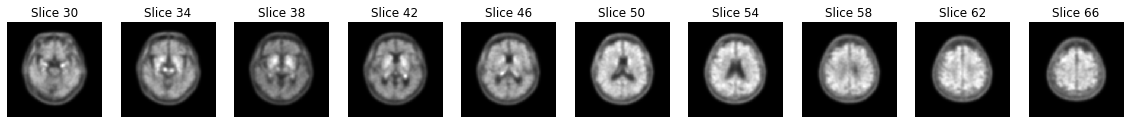

In [61]:
# useful BASH command for moving files from ADNI download: find ADNI -type f -exec mv -t . {} +
dir = ('C:/Users/Ben/Desktop/Baseline/Data/') # change this to directory with PET images     
files = os.listdir(dir)
# read in CSV description of downloaded PET scans
df = pd.read_csv('C:/Users/Ben/Downloads/Baseline_PET_All_3_20_2021.csv')
# create x and y arrays
group = []
for i in range(len(files)):
    idx = files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0]) 
group = ((np.array(group) == 'AD') / 1).reshape(-1,1)
ims = np.array([nib.load(dir + file).get_fdata() for file in files])

# these will be the slice indices used for the ensemble
def show_slices(slice):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(slice[:, : ,(30 + 4 * i), 0].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(30 + 4 * i))
# first 2 CN, second 2 AD
# use this to check a row of df based on the file index: df[df['Subject'] == files[17][5:15]]

show_slices(ims[0])
show_slices(ims[4])
show_slices(ims[14])
show_slices(ims[17])



In [62]:
split_1 = int(len(ims) * .8)
split_2 = int(len(ims) * .9)
x, y = shuffle(ims, group, random_state = 12)
x_train = x[:split_1,:,:,50]
x_val = x[split_1:split_2,:,:,50]
x_test = x[split_2:,:,:,50]
y_train = x[:split_1]
y_val = x[split_1:split_2]
y_test = x[split_2:]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(266, 160, 160, 1)
(33, 160, 160, 1)
(34, 160, 160, 1)
(266, 160, 160, 96, 1)
(33, 160, 160, 96, 1)
(34, 160, 160, 96, 1)


In [ ]:
# load model
# interpolate original images to fit resnet
# or
# concatenate to 10 layer channel, use mnist example
new_input = Input(shape = (160, 160, 1))
base_model = ResNet50(include_top = False, input_tensor = new_input, pooling = 'avg', weights = None)
x = base_model.output
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.7)(x)
predictions = layers.Dense(1, activation= 'sigmoid')(x)
model = keras.models.Model(inputs = base_model.input, outputs = predictions)

# summarize the model
model.summary()

# split data and manually change 4th index for each sub-model
split_1 = int(len(ims) * .8)
split_2 = int(len(ims) * .9)
x, y = shuffle(ims, group, random_state = 12)
x_train = x[:split_1,:,:,50]
x_val = x[split_1:split_2,:,:,50]
x_test = x[split_2:,:,:,50]
y_train = y[:split_1]
y_val = y[split_1:split_2]
y_test = y[split_2:]

batch_size = 5
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(batch_size)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(batch_size)
)


# Compile model.
#initial_learning_rate = 0.0005
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
result = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

0.18181818181818182

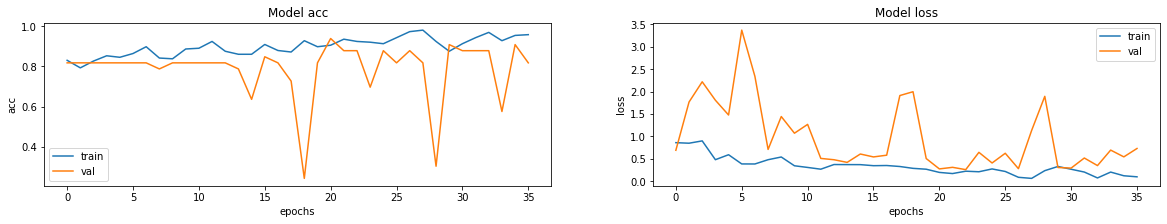

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(result.history[metric])
    ax[i].plot(result.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
y_hat = model.predict(x_val)
y_hat = y_hat > .5
accuracy_score(y_val, y_hat)